<a href="https://colab.research.google.com/github/tozanni/Data_Science_Notebooks/blob/main/CIFAR10_CNN_wNoise_SinSolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificador CNN para CIFAR10 con ruido y aumentación de datos

En este cuaderno exploraremos los siguientes conceptos:

- Agregar ruido sintético a las imágenes para simular un dataset con ruido.
- Evaluar el clasificador original en imágenes con ruido.
- Mejorar el desempeño del clasificador mediante una aumentación de datos.


In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

Verificando la cantidad de imagenes en el dataset y su dimension, en este caso recibimos 50,000 imagenes de 32x32 x 3 canales de color.

In [ ]:
# Normalizar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Datos generales
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [ ]:
# Dividir validation y test
x_val = x_test[:7000]
x_test = x_test[7000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

In [ ]:
# Etiquetas
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

### Introducción de ruido sintético

Generamos versiones "noisy" de nuestro training, test y validation set.


In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)


In [ ]:
# Funcion para mostrar imagen original e imagen con ruido
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

showOrigDec(x_train, x_train_noisy)

In [ ]:
# Se codifican las etiquetas como one-hot, posteriormente se utilizará la función de categorical-cross-entropy
num_classes = 10
y_train_labels = np_utils.to_categorical(y_train, num_classes)
y_test_labels = np_utils.to_categorical(y_test, num_classes)


In [ ]:
# Dividir etiquetas de validacion
y_val_labels = y_test_labels[:7000]
y_test_labels = y_test_labels[7000:]

## Ejercicio: 

Completa la red con las capas faltantes. Indica la opción correcta:



In [ ]:
model = Sequential()

## Ejercicio: Inserta a continuación la capa que falta al modelo:
## model.add(...)

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

El entrenamiento lo haremos con las imagenes originales, pero la validacion y pruebas con las imagenes con ruido. 

In [ ]:
history = model.fit(x_train, y_train_labels, batch_size=64, epochs=20, validation_data=(x_val_noisy, y_val_labels))

### Visualización del proceso de entrenamiento. 

Aquí puedes ver si el entrenamiento está disminuyendo la pérdida o no. En este caso ya que el validation set (noisy) no corresponde con los datos originales vamos que el modelo no consigue aprender lo suficiente para clasificar las imágenes con ruido.

En este caso, nuestro training set no es representativo de los datos esperados (noisy) y por dicha razón el entrenamiento no es idóneo.

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Del mismo modo puedes observar la calidad de la predicción en el conjunto de test. Conforme avanzan las épocas, la exactitud de la predicción (Accuracy) se va incrementando. ¿Te parece que más épocas ayudarían al modelo?

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [ ]:
# Generacion de las predicciones
pred = model.predict(x_test_noisy)
print(pred)

# Procesar las predicciones para obtener una sola clase para evaluar
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)


In [ ]:
# Graficar resultados actuales vs. pronosticados

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(x_test_noisy[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(y_test_labels[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

## Evaluación de desempeño del modelo

Nota cómo al pasar imágenes con ruido a un clasificador que no está preparado para ellas, el resultado de la clasificación se degrada bastante.

### Ejercicio:

Genera la matriz de confusión del modelo original, con el dataset ruidoso. Escribe tu respuesta a continuación. 


In [ ]:
## TIP: El código para calcular la matriz de confusión lo puedes obtener del ejercicio pasado


## Mejora del desempeño con aumentación de datos (Accion 3)

Para tratar de disminuir el daño ocasionado por el ruido a nuestro clasificador, una técnica que podemos utilizar es la aumentación de datos. 

En este caso, entrenaremos el clasificador en las imágenes con y sin ruido, de tal forma que lo hagamos más robusto ante este fenómeno. 

Es decir, con esta técnica estamos haciendo que nuestro clasificador aprenda a clasificar imágenes con ruido y sin ruido.

## Ejercicio:

Genera un conjunto de datos aumentado x_train_aug y y_train_aug, concatenando los datos originales (x_train) con los datos con ruido (x_train_noisy) así como sus etiquetas de entrenamiento. 

In [ ]:
## Escribe aquí tu respuesta

print(x_train_aug.shape)
print(y_train_aug.shape)

(100000, 32, 32, 3)
(100000, 10)


In [ ]:
# Entrenamos el modelo con el dataset aumentado, utilizamos las imagenes con ruido para validacion

history = model.fit(x_train_aug, y_train_aug, batch_size=64, epochs=20, validation_data=(x_val_noisy, y_val_labels))


Epoch 1/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0284 - accuracy: 0.6403 - val_loss: 1.1742 - val_accuracy: 0.5794
Epoch 2/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9241 - accuracy: 0.6768 - val_loss: 1.0982 - val_accuracy: 0.6059
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8889 - accuracy: 0.6892 - val_loss: 1.0395 - val_accuracy: 0.6271
Epoch 4/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8637 - accuracy: 0.6977 - val_loss: 1.0452 - val_accuracy: 0.6290
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8498 - accuracy: 0.7033 - val_loss: 1.0094 - val_accuracy: 0.6410
Epoch 6/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8278 - accuracy: 0.7106 - val_loss: 1.0088 - val_accuracy: 0.6413
Epoch 7/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8128 - accuracy: 0.7169 - val_loss: 1.0207 -

Text(0.5, 1.0, 'Loss Curves')

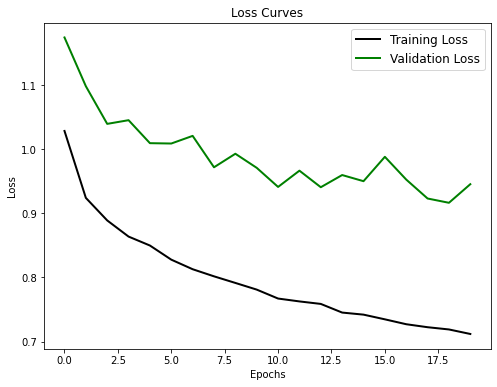

In [ ]:
# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

## Ejecutar predicciones del modelo 

Ejercicio: Utiliza x_test_noisy para obtener las etiquetas del dataset de pruebas con ruido.


Ejercicio: Obten la matriz de confusión para el modelo aumentado.

Este resultado muestra cómo se ha recuperado una gran parte del poder predictivo del clasificador utilizando la aumentación de datos.

Ahora tienes un clasificador capaz de procesar imágenes con un alto nivel de ruido.

Sin embargo, este modelo no te permite obtener una versión sin ruido de la imagen, para lo cual es necesario implementar un autoencoder. 

Referencia: 

https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook

